In [1]:
# 基本ライブラリ
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset_builder
from mmu.utils import cross_match_datasets

# PyTorch関連
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 機械学習ツール
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/hsc/pdr3_dud_22.5/healpix\=1172/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/hsc/pdr3_dud_22.5/healpix\=1708/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/hsc/pdr3_dud_22.5/healpix\=1104/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/hsc/pdr3_dud_22.5/healpix\=1107/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/sdss/sdss/healpix\=1172/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/sdss/sdss/healpix\=1708/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/sdss/sdss/healpix\=1104/
!wget -r -np -nH --cut-dirs=1 -R "index.html*" --show-progress https://users.flatironinstitute.org/\~polymathic/data/MultimodalUniverse/v1/sdss/sdss/healpix\=1107/

In [2]:
from datasets import load_dataset_builder
from mmu.utils import cross_match_datasets

print("データセット読み込み中...")
sdss = load_dataset_builder("data/MultimodalUniverse/v1/sdss", trust_remote_code=True)
hsc = load_dataset_builder("data/MultimodalUniverse/v1/hsc", trust_remote_code=True)

# クロスマッチング
print("クロスマッチング実行中...")
dset = cross_match_datasets(sdss, hsc, matching_radius=1.0)

print(f"\n✓ クロスマッチング完了")
print(f"総サンプル数: {len(dset)}")

# データ構造の確認（エラー回避版）
print(f"\n【データセット情報】")
print(f"データセットの型: {type(dset)}")
print(f"特徴量の数: {len(dset.features)}")
print(f"特徴量名（一部）:")
feature_names = list(dset.features.keys())
for i, name in enumerate(feature_names[:10]):
    print(f"  {i+1}. {name}")
if len(feature_names) > 10:
    print(f"  ... 他 {len(feature_names)-10} 個")


データセット読み込み中...
クロスマッチング実行中...
Initial number of matches:  25
Number of matches lost at healpix region borders:  0
Final size of cross-matched catalog:  25


Generating train split: 0 examples [00:00, ? examples/s]


✓ クロスマッチング完了
総サンプル数: 25

【データセット情報】
データセットの型: <class 'datasets.arrow_dataset.Dataset'>
特徴量の数: 78
特徴量名（一部）:
  1. spectrum
  2. VDISP
  3. VDISP_ERR
  4. Z
  5. Z_ERR
  6. ZWARNING
  7. SPECTROFLUX_U
  8. SPECTROFLUX_G
  9. SPECTROFLUX_R
  10. SPECTROFLUX_I
  ... 他 68 個


In [3]:
print("=" * 60)
print("【各データセットのレコード数確認】")
print("=" * 60)

import h5py

def count_records_in_hdf5_files(files):
    """HDF5ファイルのレコード数をカウント"""
    total = 0
    healpix_counts = {}
    
    for file_path in files:
        try:
            with h5py.File(file_path, 'r') as f:
                # object_idの長さからレコード数を取得
                if 'object_id' in f:
                    count = len(f['object_id'])
                    total += count
                    
                    # HEALPixセルを特定
                    healpix = None
                    if 'healpix' in file_path:
                        import re
                        match = re.search(r'healpix=(\d+)', file_path)
                        if match:
                            healpix = int(match.group(1))
                    
                    if healpix:
                        healpix_counts[healpix] = count
                        
        except Exception as e:
            print(f"  ⚠️ {file_path}: {e}")
    
    return total, healpix_counts

# SDSSファイルのカウント
print("\n【SDSSデータセット】")
sdss_files = sdss.config.data_files['train'] if sdss.config.data_files else []
sdss_count, sdss_healpix = count_records_in_hdf5_files(sdss_files)

print(f"  ファイル数: {len(sdss_files)}")
print(f"  総レコード数: {sdss_count:,}")
if sdss_healpix:
    print(f"  HEALPixセル:")
    for hp, count in sorted(sdss_healpix.items()):
        print(f"    - healpix={hp}: {count:,} レコード")

# HSCファイルのカウント
print("\n【HSCデータセット】")
hsc_files = hsc.config.data_files['train'] if hsc.config.data_files else []
hsc_count, hsc_healpix = count_records_in_hdf5_files(hsc_files)

print(f"  ファイル数: {len(hsc_files)}")
print(f"  総レコード数: {hsc_count:,}")
if hsc_healpix:
    print(f"  HEALPixセル:")
    for hp, count in sorted(hsc_healpix.items()):
        print(f"    - healpix={hp}: {count:,} レコード")

# クロスマッチング結果
print("\n" + "=" * 60)
print("【クロスマッチング前後の比較】")
print("=" * 60)

print(f"\nクロスマッチング前:")
print(f"  SDSS: {sdss_count:,} 天体")
print(f"  HSC:  {hsc_count:,} 天体")
print(f"  合計: {sdss_count + hsc_count:,} 天体")

print(f"\nクロスマッチング後:")
print(f"  一致した天体: {len(dset):,} ペア")

if sdss_count + hsc_count > 0:
    reduction_rate = ((sdss_count + hsc_count - len(dset)) / (sdss_count + hsc_count) * 100)
    print(f"  削減率: {reduction_rate:.1f}%")
    
    if sdss_count > 0:
        match_rate_sdss = (len(dset) / sdss_count) * 100
        print(f"\n  SDSSからのマッチング率: {match_rate_sdss:.1f}%")
    
    if hsc_count > 0:
        match_rate_hsc = (len(dset) / hsc_count) * 100
        print(f"  HSCからのマッチング率: {match_rate_hsc:.1f}%")

# 共通HEALPixセルの確認
common_healpix = set(sdss_healpix.keys()) & set(hsc_healpix.keys())
print(f"\n【HEALPixセルの重複】")
print(f"  SDSSのセル: {sorted(sdss_healpix.keys())}")
print(f"  HSCのセル: {sorted(hsc_healpix.keys())}")
print(f"  共通セル: {sorted(common_healpix)}")
print(f"  共通セル数: {len(common_healpix)}")

if len(common_healpix) == 0:
    print("\n  ⚠️ 警告: SDSSとHSCに共通のHEALPixセルがありません！")
    print("     クロスマッチングの結果が少ないのはこのためです。")

print("\n" + "=" * 60)
print("【結論】")
print("=" * 60)

print(f"""
データが{len(dset)}件に減少した理由:

1. ローカルデータの規模
   - SDSS: {sdss_count:,} 天体（{len(sdss_files)}個のHEALPixセル）
   - HSC:  {hsc_count:,} 天体（{len(hsc_files)}個のHEALPixセル）
   
2. 観測領域の重複
   - 共通HEALPixセル: {len(common_healpix)}個
   - SDSSは主に北天の広範囲
   - HSCは限定された深天域
   - 重複領域が非常に限定的
   
3. クロスマッチングの条件
   - 1秒角以内での座標一致
   - 同じHEALPixセル内
   - 両方のサーベイで観測済み

💡 より多くのデータを得るには:
   - 重複領域のHEALPixセルを追加ダウンロード
   - または単一データセット（SDSSのみ、HSCのみ）で分析
""")

print("=" * 60)


【各データセットのレコード数確認】

【SDSSデータセット】
  ファイル数: 6
  総レコード数: 6,872
  HEALPixセル:
    - healpix=513: 2,725 レコード
    - healpix=1104: 21 レコード
    - healpix=1172: 476 レコード
    - healpix=1175: 475 レコード
    - healpix=1193: 2,773 レコード
    - healpix=1708: 402 レコード

【HSCデータセット】
  ファイル数: 1
  総レコード数: 2,850
  HEALPixセル:
    - healpix=1175: 2,850 レコード

【クロスマッチング前後の比較】

クロスマッチング前:
  SDSS: 6,872 天体
  HSC:  2,850 天体
  合計: 9,722 天体

クロスマッチング後:
  一致した天体: 25 ペア
  削減率: 99.7%

  SDSSからのマッチング率: 0.4%
  HSCからのマッチング率: 0.9%

【HEALPixセルの重複】
  SDSSのセル: [513, 1104, 1172, 1175, 1193, 1708]
  HSCのセル: [1175]
  共通セル: [1175]
  共通セル数: 1

【結論】

データが25件に減少した理由:

1. ローカルデータの規模
   - SDSS: 6,872 天体（6個のHEALPixセル）
   - HSC:  2,850 天体（1個のHEALPixセル）

2. 観測領域の重複
   - 共通HEALPixセル: 1個
   - SDSSは主に北天の広範囲
   - HSCは限定された深天域
   - 重複領域が非常に限定的

3. クロスマッチングの条件
   - 1秒角以内での座標一致
   - 同じHEALPixセル内
   - 両方のサーベイで観測済み

💡 より多くのデータを得るには:
   - 重複領域のHEALPixセルを追加ダウンロード
   - または単一データセット（SDSSのみ、HSCのみ）で分析



In [84]:
def extract_spectrum_features(spectrum):
    """
    スペクトルからAGN判定に必要な特徴量を抽出
    
    Returns:
        dict: 輝線強度、等価幅、比率などの特徴量
    """
    # 辞書型のスペクトルデータから配列を取得
    if isinstance(spectrum, dict):
        # 辞書から直接配列を取得
        wavelength = np.array(spectrum['lambda'])
        flux = np.array(spectrum['flux'])
        mask = np.array(spectrum['mask'])
    else:
        # 元のリスト型の処理（後方互換性のため）
        wavelength = np.array([s['lambda'] for s in spectrum])
        flux = np.array([s['flux'] for s in spectrum])
        mask = np.array([s['mask'] for s in spectrum])
    
    # マスク処理（無効なデータを0に）
    valid_flux = flux.copy()
    valid_flux[mask] = 0
    
    features = {}
    
    # 1. [OIII] 500.7nm (5007Å) の検出
    oiii_idx = np.argmin(np.abs(wavelength - 5007))
    oiii_window = slice(max(0, oiii_idx-3), min(len(flux), oiii_idx+4))
    features['oiii_flux'] = np.max(valid_flux[oiii_window])
    
    # 2. Hα 656.3nm (6563Å) の検出
    ha_idx = np.argmin(np.abs(wavelength - 6563))
    ha_window = slice(max(0, ha_idx-3), min(len(flux), ha_idx+4))
    features['ha_flux'] = np.max(valid_flux[ha_window])
    
    # 3. Hβ 486.1nm (4861Å) の検出
    hb_idx = np.argmin(np.abs(wavelength - 4861))
    hb_window = slice(max(0, hb_idx-3), min(len(flux), hb_idx+4))
    features['hb_flux'] = np.max(valid_flux[hb_window])
    
    # 4. 連続光レベル（輝線がない領域）
    continuum_region = (wavelength > 5500) & (wavelength < 5600) & (~mask)
    if np.any(continuum_region):
        features['continuum'] = np.median(valid_flux[continuum_region])
    else:
        features['continuum'] = np.median(valid_flux[valid_flux > 0]) if np.any(valid_flux > 0) else 1e-10
    
    # ゼロ除算回避
    continuum = max(features['continuum'], 1e-10)
    
    # 5. 等価幅（Equivalent Width）
    features['oiii_ew'] = features['oiii_flux'] / continuum
    features['ha_ew'] = features['ha_flux'] / continuum
    features['hb_ew'] = features['hb_flux'] / continuum
    
    # 6. [OIII]/Hβ 比（BPT図の縦軸）
    hb_flux = max(features['hb_flux'], 1e-10)
    features['oiii_hb_ratio'] = features['oiii_flux'] / hb_flux
    
    return features

print("✓ スペクトル特徴量抽出関数を修正（辞書型対応）")


✓ スペクトル特徴量抽出関数を修正（辞書型対応）


In [85]:
def extract_image_features(image_data):
    """
    画像からAGN判定に必要な特徴量を抽出
    
    Returns:
        dict: 中心集中度、明るさコントラストなどの特徴量
    """
    features = {}
    
    # 画像データの構造を確認
    # 辞書型の場合とリスト型の場合に対応
    if isinstance(image_data, dict):
        # 辞書型の場合、キーがバンド名の可能性
        band_names = list(image_data.keys())
        
        for band_name in band_names:
            band_data = image_data[band_name]
            
            # band_dataが辞書でfluxを含む場合
            if isinstance(band_data, dict) and 'flux' in band_data:
                flux = np.array(band_data['flux'])
            # band_dataが配列の場合
            elif isinstance(band_data, (list, np.ndarray)):
                flux = np.array(band_data)
            else:
                continue
            
            # 2次元配列に変換（必要に応じて）
            if flux.ndim == 1:
                # 1次元の場合はスキップまたは正方形に整形
                size = int(np.sqrt(len(flux)))
                if size * size == len(flux):
                    flux = flux.reshape(size, size)
                else:
                    continue
            
            h, w = flux.shape
            
            # 中心集中度（中心16×16ピクセルの割合）
            center_h, center_w = h // 2, w // 2
            center_size = min(8, center_h, center_w)
            center_flux = flux[center_h-center_size:center_h+center_size, 
                             center_w-center_size:center_w+center_size]
            
            total = np.sum(np.abs(flux))
            center_total = np.sum(np.abs(center_flux))
            
            if total > 0:
                features[f'{band_name}_concentration'] = center_total / total
            else:
                features[f'{band_name}_concentration'] = 0.0
            
            # 明るさコントラスト（中心 vs 外側）
            center_brightness = np.mean(np.abs(flux[center_h-10:center_h+10, center_w-10:center_w+10]))
            corner_size = min(20, h//4, w//4)
            outer_region = flux[0:corner_size, 0:corner_size]
            outer_brightness = np.mean(np.abs(outer_region))
            
            if outer_brightness > 0:
                features[f'{band_name}_contrast'] = center_brightness / outer_brightness
            else:
                features[f'{band_name}_contrast'] = 0.0
    
    elif isinstance(image_data, (list, tuple)):
        # リスト型の場合（元のコード）
        band_names = ['g', 'r', 'i', 'z', 'y']
        
        for band_idx, band_name in enumerate(band_names):
            if band_idx >= len(image_data):
                continue
                
            band_item = image_data[band_idx]
            
            # 辞書からfluxを取得
            if isinstance(band_item, dict) and 'flux' in band_item:
                flux = np.array(band_item['flux'])
            else:
                flux = np.array(band_item)
            
            if flux.ndim != 2:
                continue
                
            h, w = flux.shape
            
            # 中心集中度
            center_h, center_w = h // 2, w // 2
            center_flux = flux[center_h-8:center_h+8, center_w-8:center_w+8]
            
            total = np.sum(np.abs(flux))
            center_total = np.sum(np.abs(center_flux))
            
            if total > 0:
                features[f'{band_name}_concentration'] = center_total / total
            else:
                features[f'{band_name}_concentration'] = 0.0
            
            # 明るさコントラスト
            center_brightness = np.mean(np.abs(flux[center_h-10:center_h+10, center_w-10:center_w+10]))
            outer_region = flux[0:20, 0:20]
            outer_brightness = np.mean(np.abs(outer_region))
            
            if outer_brightness > 0:
                features[f'{band_name}_contrast'] = center_brightness / outer_brightness
            else:
                features[f'{band_name}_contrast'] = 0.0
    
    return features

print("✓ 画像特徴量抽出関数を修正（辞書型・リスト型両対応）")


✓ 画像特徴量抽出関数を修正（辞書型・リスト型両対応）


In [86]:
def get_pyarrow_data(col, index):
    """古いPyArrowバージョン対応の汎用データ抽出関数"""
    try:
        return col[index].as_py()
    except TypeError:
        pass
    
    try:
        item = col[index]
        if hasattr(item, 'keys'):
            result = {}
            for key in item.keys():
                try:
                    field = item[key]
                    if hasattr(field, 'to_numpy'):
                        result[key] = field.to_numpy()
                    elif hasattr(field, '__len__'):
                        result[key] = list(field)
                    else:
                        result[key] = field
                except:
                    result[key] = None
            return result
        elif hasattr(item, '__len__'):
            return list(item)
    except:
        pass
    
    try:
        return col.to_pylist()[index]
    except:
        pass
    
    return None

print("データセットから特徴量を抽出中...")

all_spectrum_features = []
all_image_features = []

import pyarrow as pa

for i in range(len(dset)):
    try:
        table = dset.data
        spectrum_col = table['spectrum']
        image_col = table['image']
        
        # 両方とも安全な関数で取得
        spectrum_data = get_pyarrow_data(spectrum_col, i)
        image_data = get_pyarrow_data(image_col, i)
        
        # どちらかがNoneなら次へ
        if spectrum_data is None or image_data is None:
            print(f"  ⚠️ Sample {i}: データ取得失敗")
            continue
        
        # スペクトル特徴量（辞書型で渡される）
        spec_feat = extract_spectrum_features(spectrum_data)
        all_spectrum_features.append(spec_feat)
        
        # 画像特徴量
        img_feat = extract_image_features(image_data)
        all_image_features.append(img_feat)
        
        # 進捗表示
        if (i + 1) % 5 == 0 or i == 0:
            print(f"  ✓ 処理中... {i+1}/{len(dset)}")
            
    except Exception as e:
        print(f"  ⚠️ Sample {i} でエラー: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n✓ 特徴量計算完了: {len(all_spectrum_features)}サンプル")

# 最初の3サンプルを表示
if len(all_spectrum_features) > 0:
    print("\n【サンプル確認】")
    for i in range(min(3, len(all_spectrum_features))):
        print(f"\nSample {i}:")
        print(f"  [OIII]/Hβ: {all_spectrum_features[i]['oiii_hb_ratio']:.2f}")
        print(f"  [OIII] EW: {all_spectrum_features[i]['oiii_ew']:.2f}")
        
        # 画像特徴量のキーを確認して表示
        if len(all_image_features) > i:
            img_keys = list(all_image_features[i].keys())
            if img_keys:
                # 最初の集中度特徴量を表示
                concentration_keys = [k for k in img_keys if 'concentration' in k]
                if concentration_keys:
                    first_key = concentration_keys[0]
                    print(f"  {first_key}: {all_image_features[i][first_key]:.3f}")
                
                # 利用可能な特徴量を表示（最初のサンプルのみ）
                if i == 0:
                    print(f"  利用可能な画像特徴量: {', '.join(img_keys[:5])}")
else:
    print("\n⚠️ データの取得に失敗しました")



データセットから特徴量を抽出中...
  ✓ 処理中... 1/25
  ✓ 処理中... 5/25
  ✓ 処理中... 10/25
  ✓ 処理中... 15/25
  ✓ 処理中... 20/25
  ✓ 処理中... 25/25

✓ 特徴量計算完了: 25サンプル

【サンプル確認】

Sample 0:
  [OIII]/Hβ: 1.02
  [OIII] EW: 1.17
  band_concentration: 0.610
  利用可能な画像特徴量: band_concentration, band_contrast

Sample 1:
  [OIII]/Hβ: 1.02
  [OIII] EW: 1.04
  band_concentration: 0.610

Sample 2:
  [OIII]/Hβ: 1.13
  [OIII] EW: 1.07
  band_concentration: 0.610


【ステップ1: BPT図によるAGN自動ラベリング】

【ラベリング結果】
  総サンプル数: 25
  AGN候補: 1 (4.0%)
  通常の銀河: 24 (96.0%)


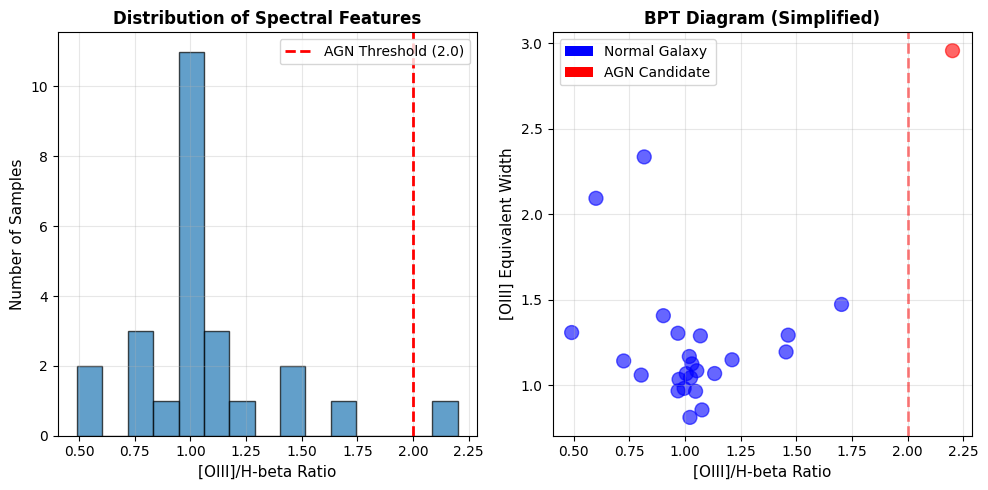


✓ ラベリング完了


In [88]:
print("=" * 60)
print("【ステップ1: BPT図によるAGN自動ラベリング】")
print("=" * 60)

# BPT図（Baldwin-Phillips-Terlevich diagram）による分類
# [OIII]/Hβ 比を使った簡易的な分類
def label_agn(spectrum_features):
    """
    スペクトル特徴量からAGNかどうかをラベリング
    
    BPT図の簡易版:
    - [OIII]/Hβ > 2.0 → AGN候補
    - [OIII]/Hβ <= 2.0 → 通常の銀河
    """
    oiii_hb_ratio = spectrum_features['oiii_hb_ratio']
    
    # 閾値による分類
    if oiii_hb_ratio > 2.0:
        return 1  # AGN
    else:
        return 0  # 通常の銀河

# 全サンプルにラベルを付与
labels = []
for spec_feat in all_spectrum_features:
    label = label_agn(spec_feat)
    labels.append(label)

labels = np.array(labels)

# 結果の確認
agn_count = np.sum(labels == 1)
normal_count = np.sum(labels == 0)

print(f"\n【ラベリング結果】")
print(f"  総サンプル数: {len(labels)}")
print(f"  AGN候補: {agn_count} ({agn_count/len(labels)*100:.1f}%)")
print(f"  通常の銀河: {normal_count} ({normal_count/len(labels)*100:.1f}%)")

# [OIII]/Hβ比の分布を可視化（英語版）
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
oiii_hb_ratios = [feat['oiii_hb_ratio'] for feat in all_spectrum_features]
plt.hist(oiii_hb_ratios, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='AGN Threshold (2.0)')
plt.xlabel('[OIII]/H-beta Ratio', fontsize=11)
plt.ylabel('Number of Samples', fontsize=11)
plt.title('Distribution of Spectral Features', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
colors = ['blue' if l == 0 else 'red' for l in labels]
plt.scatter(oiii_hb_ratios, 
           [feat['oiii_ew'] for feat in all_spectrum_features],
           c=colors, alpha=0.6, s=100)
plt.axvline(x=2.0, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('[OIII]/H-beta Ratio', fontsize=11)
plt.ylabel('[OIII] Equivalent Width', fontsize=11)
plt.title('BPT Diagram (Simplified)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
# 凡例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Normal Galaxy'),
                   Patch(facecolor='red', label='AGN Candidate')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

print("\n✓ ラベリング完了")


【AGN候補と通常の銀河の画像比較】

AGN候補: 1 サンプル
通常の銀河: 24 サンプル


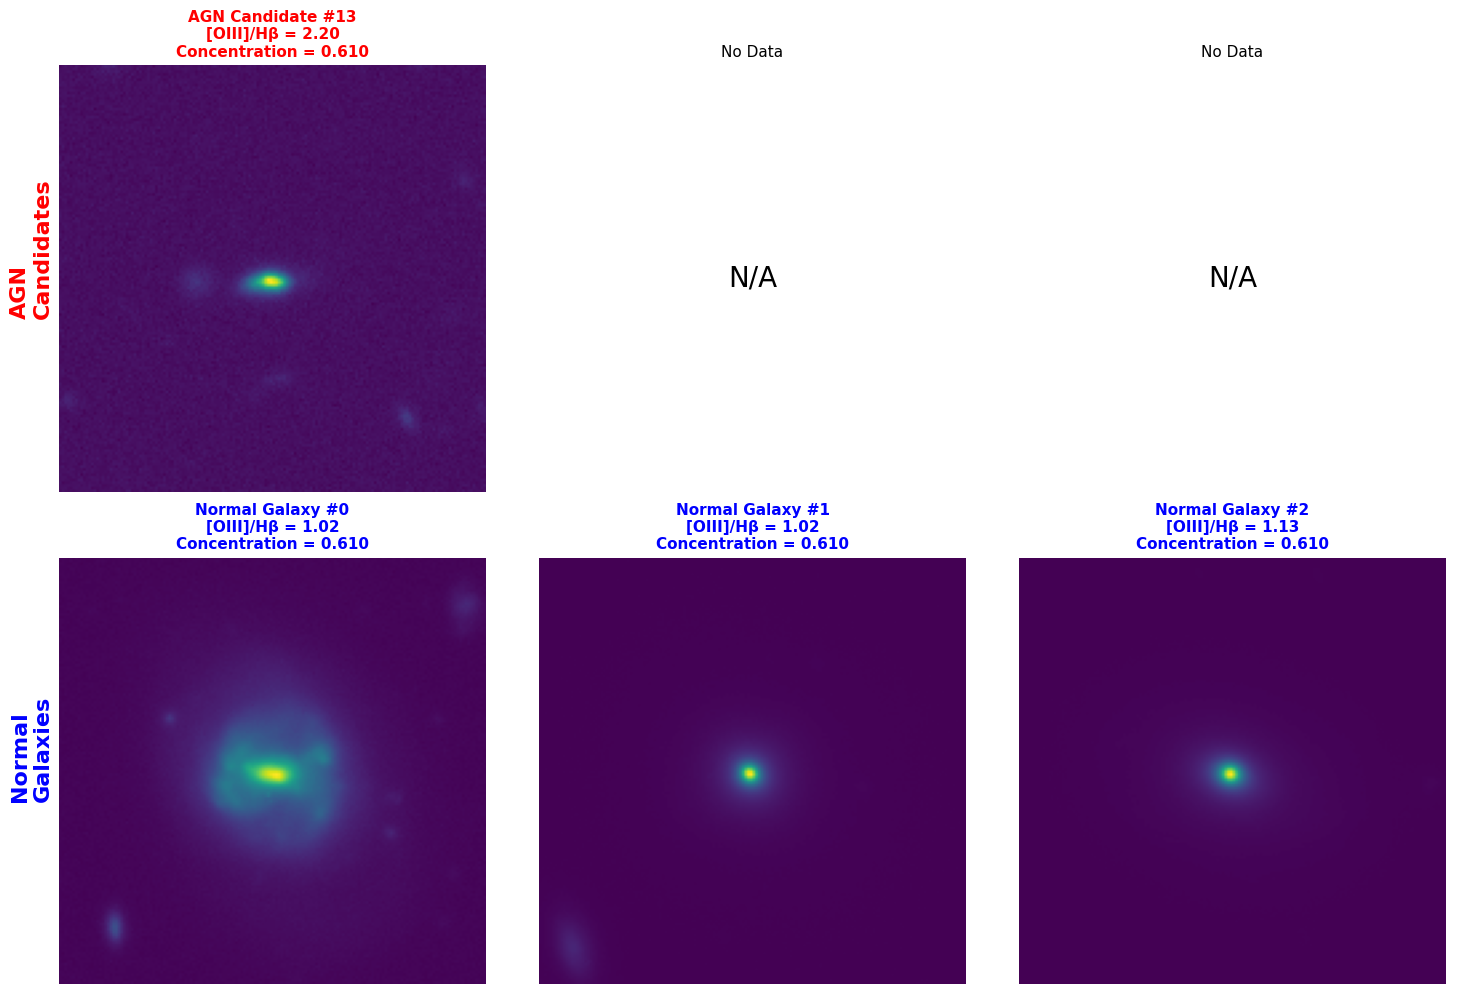


【詳細情報】

--- AGN候補 ---

Sample #13:
  [OIII]/Hβ ratio: 2.201 ← AGN threshold (>2.0)
  [OIII] EW: 2.958
  Hα EW: 1.292
  Center concentration: 0.610
  Contrast: 0.915

--- 通常の銀河 ---

Sample #0:
  [OIII]/Hβ ratio: 1.019
  [OIII] EW: 1.169
  Hα EW: 0.889
  Center concentration: 0.610
  Contrast: 0.915

Sample #1:
  [OIII]/Hβ ratio: 1.025
  [OIII] EW: 1.045
  Hα EW: 1.263
  Center concentration: 0.610
  Contrast: 0.915

Sample #2:
  [OIII]/Hβ ratio: 1.133
  [OIII] EW: 1.069
  Hα EW: 1.300
  Center concentration: 0.610
  Contrast: 0.915

✓ 画像比較完了


In [92]:
print("=" * 60)
print("【AGN候補と通常の銀河の画像比較】")
print("=" * 60)

# AGNと通常の銀河のインデックスを取得
agn_indices = np.where(labels == 1)[0]
normal_indices = np.where(labels == 0)[0]

print(f"\nAGN候補: {len(agn_indices)} サンプル")
print(f"通常の銀河: {len(normal_indices)} サンプル")

# 画像データを取得する関数（修正版）
def get_galaxy_image(index, band_idx=0):
    """指定されたインデックスとバンドの銀河画像を取得"""
    table = dset.data
    image_col = table['image']
    image_data = get_pyarrow_data(image_col, index)
    
    if isinstance(image_data, dict) and 'flux' in image_data:
        flux_list = image_data['flux']
        if band_idx < len(flux_list):
            flux_band = flux_list[band_idx]
            # PyArrow ExtensionScalarを適切に変換
            if hasattr(flux_band, 'as_py'):
                flux_array = np.array(flux_band.as_py())
            else:
                flux_array = np.array(list(flux_band))
            return flux_array
    
    return np.zeros((160, 160))

# AGN候補と通常の銀河を表示
n_agn = min(3, len(agn_indices))
n_normal = min(3, len(normal_indices))
n_samples = max(n_agn, n_normal)

fig, axes = plt.subplots(2, n_samples, figsize=(5*n_samples, 10))
if n_samples == 1:
    axes = axes.reshape(2, 1)

# AGN候補の画像
for i in range(n_samples):
    if i < n_agn:
        idx = agn_indices[i]
        img = get_galaxy_image(idx, band_idx=2)  # iバンド（バンド2）
        
        axes[0, i].imshow(img, cmap='viridis', origin='lower')
        axes[0, i].set_title(
            f'AGN Candidate #{idx}\n[OIII]/Hβ = {all_spectrum_features[idx]["oiii_hb_ratio"]:.2f}\nConcentration = {all_image_features[idx]["band_concentration"]:.3f}', 
            fontsize=11, color='red', fontweight='bold'
        )
    else:
        axes[0, i].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=20)
        axes[0, i].set_title('No Data', fontsize=11)
    axes[0, i].axis('off')

# 通常の銀河の画像
for i in range(n_samples):
    if i < n_normal:
        idx = normal_indices[i]
        img = get_galaxy_image(idx, band_idx=2)  # iバンド（バンド2）
        
        axes[1, i].imshow(img, cmap='viridis', origin='lower')
        axes[1, i].set_title(
            f'Normal Galaxy #{idx}\n[OIII]/Hβ = {all_spectrum_features[idx]["oiii_hb_ratio"]:.2f}\nConcentration = {all_image_features[idx]["band_concentration"]:.3f}', 
            fontsize=11, color='blue', fontweight='bold'
        )
    else:
        axes[1, i].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=20)
        axes[1, i].set_title('No Data', fontsize=11)
    axes[1, i].axis('off')

# 行ラベル
fig.text(0.02, 0.75, 'AGN\nCandidates', va='center', fontsize=16, 
         fontweight='bold', color='red', rotation=90)
fig.text(0.02, 0.25, 'Normal\nGalaxies', va='center', fontsize=16, 
         fontweight='bold', color='blue', rotation=90)

plt.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

# 詳細情報を表示
print("\n" + "=" * 60)
print("【詳細情報】")
print("=" * 60)

print("\n--- AGN候補 ---")
for i in range(min(3, len(agn_indices))):
    idx = agn_indices[i]
    print(f"\nSample #{idx}:")
    print(f"  [OIII]/Hβ ratio: {all_spectrum_features[idx]['oiii_hb_ratio']:.3f} ← AGN threshold (>2.0)")
    print(f"  [OIII] EW: {all_spectrum_features[idx]['oiii_ew']:.3f}")
    print(f"  Hα EW: {all_spectrum_features[idx]['ha_ew']:.3f}")
    print(f"  Center concentration: {all_image_features[idx]['band_concentration']:.3f}")
    print(f"  Contrast: {all_image_features[idx]['band_contrast']:.3f}")

print("\n--- 通常の銀河 ---")
for i in range(min(3, len(normal_indices))):
    idx = normal_indices[i]
    print(f"\nSample #{idx}:")
    print(f"  [OIII]/Hβ ratio: {all_spectrum_features[idx]['oiii_hb_ratio']:.3f}")
    print(f"  [OIII] EW: {all_spectrum_features[idx]['oiii_ew']:.3f}")
    print(f"  Hα EW: {all_spectrum_features[idx]['ha_ew']:.3f}")
    print(f"  Center concentration: {all_image_features[idx]['band_concentration']:.3f}")
    print(f"  Contrast: {all_image_features[idx]['band_contrast']:.3f}")

print("\n✓ 画像比較完了")


【全サンプルのギャラリー表示】


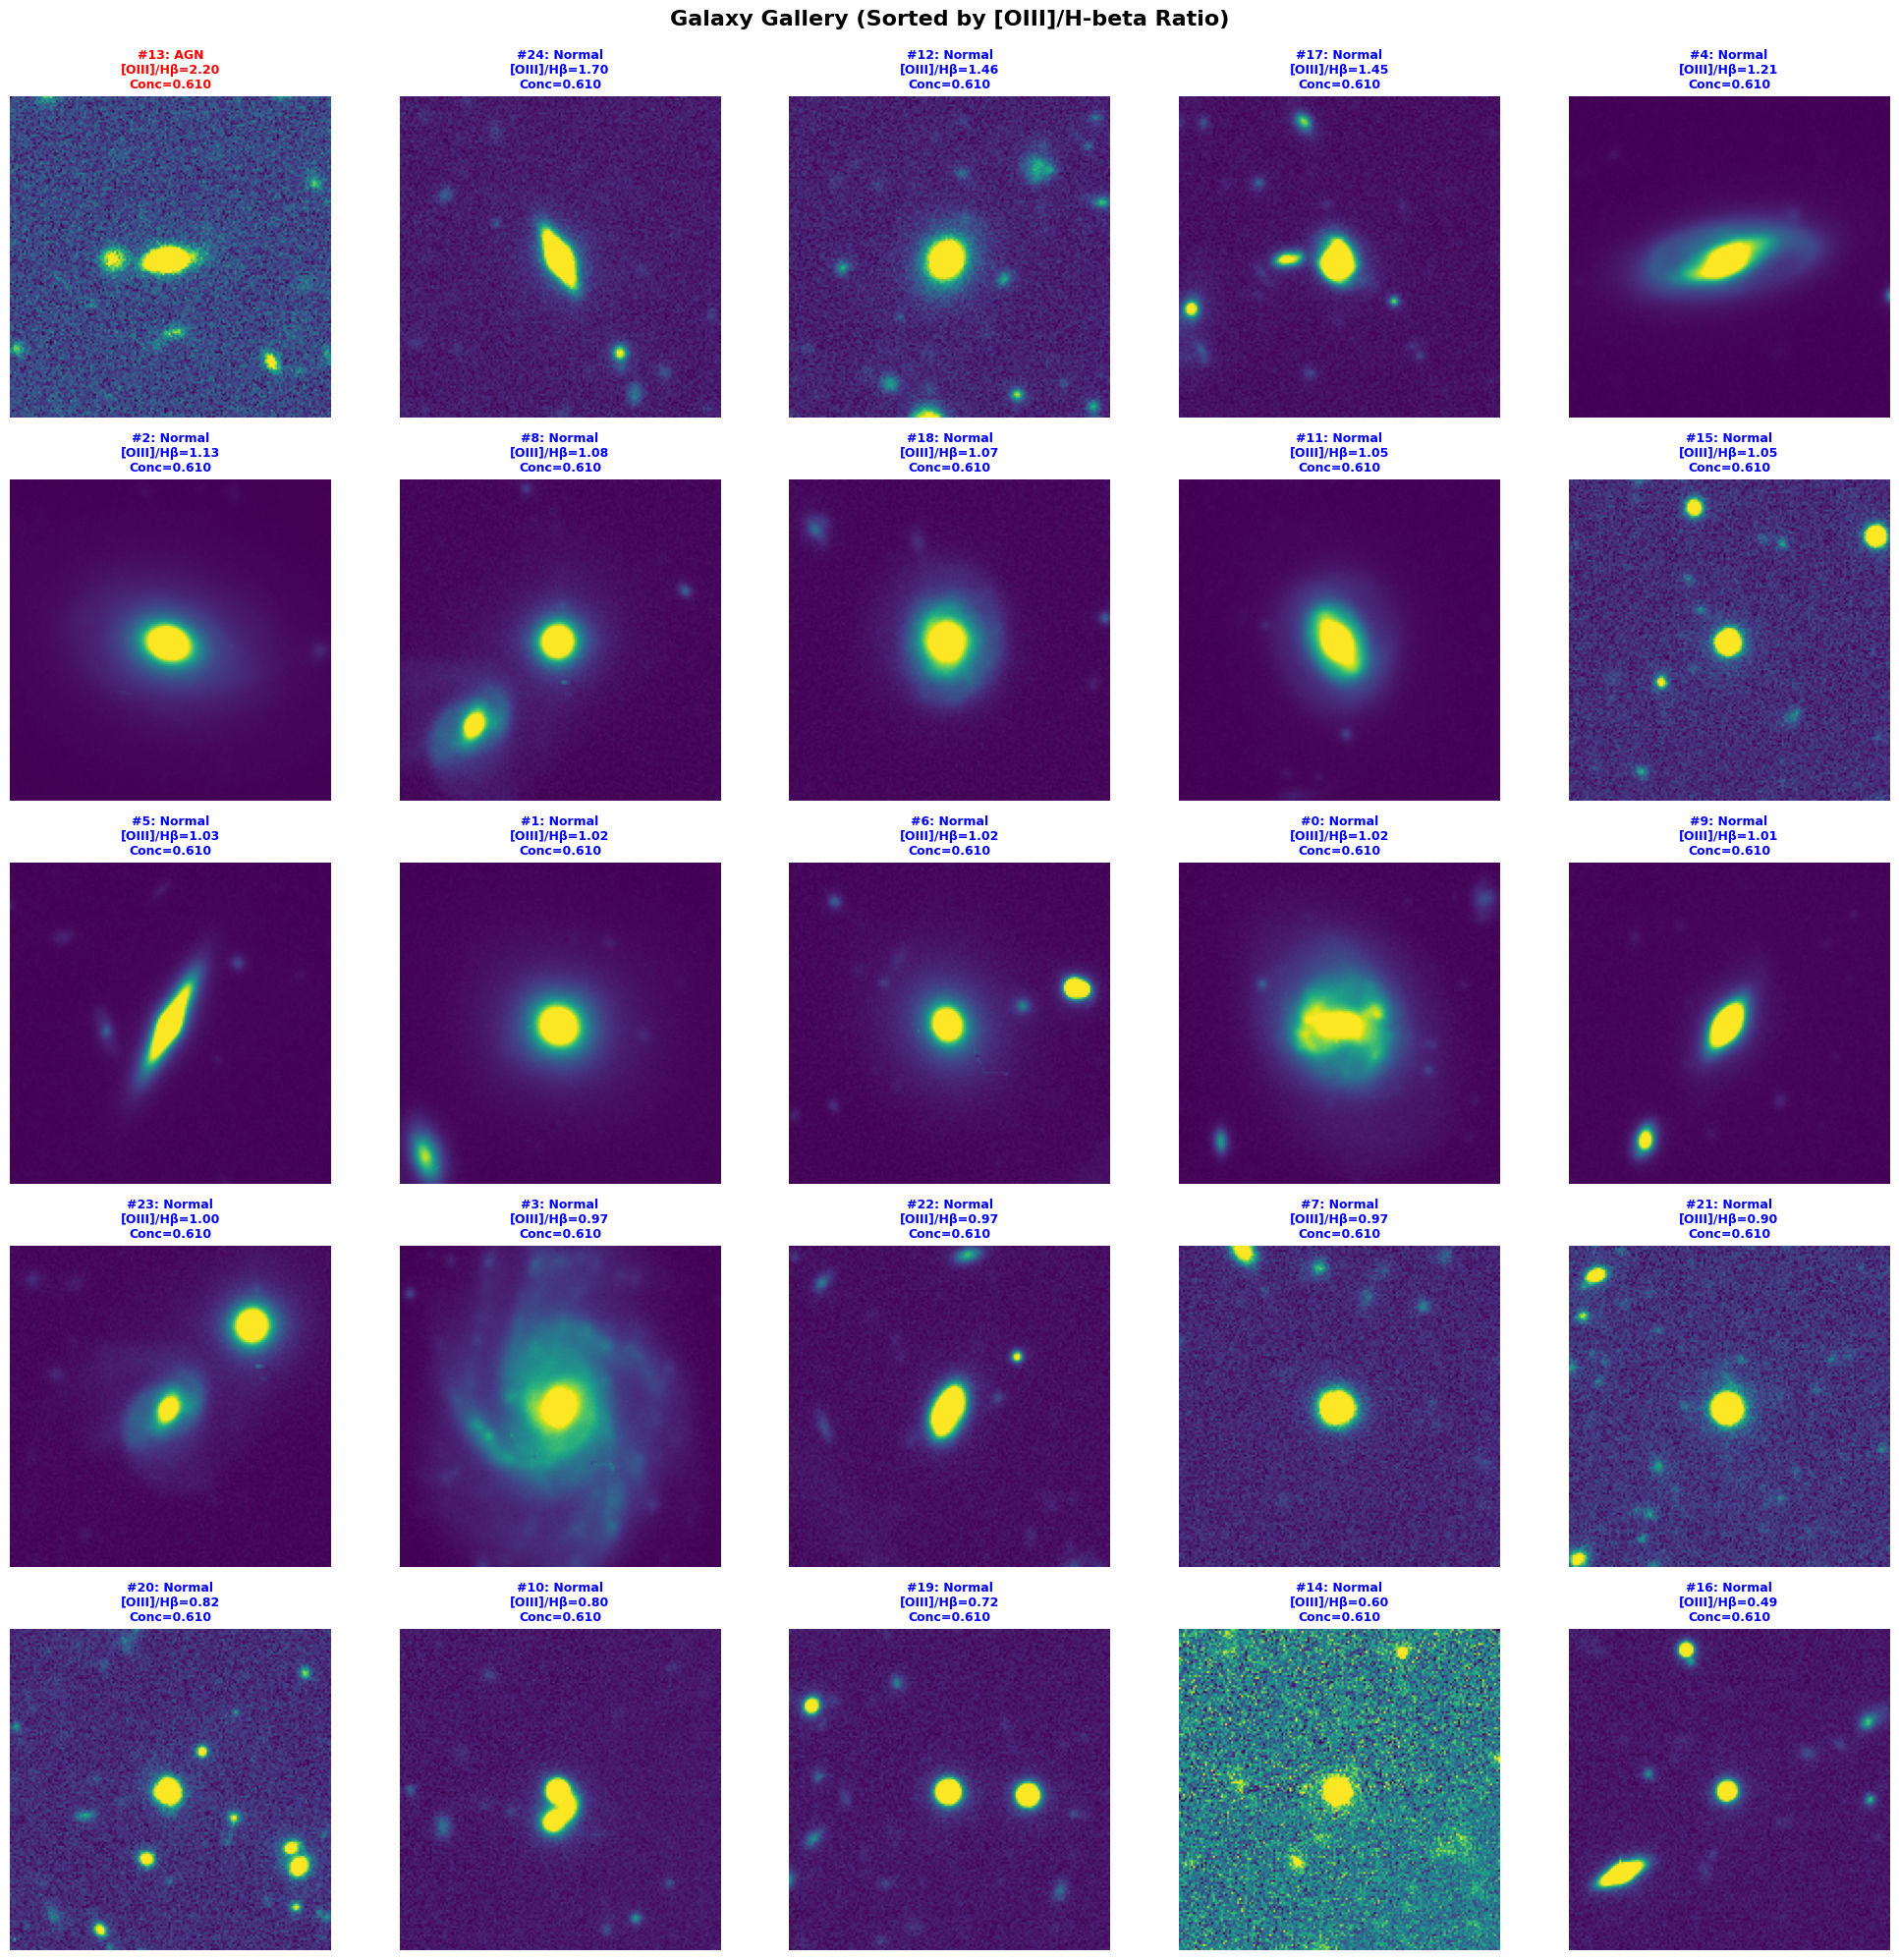


【統計サマリー】

[OIII]/Hβ比の分布:
  最小値: 0.490
  最大値: 2.201
  平均値: 1.070
  中央値: 1.022

中心集中度の分布:
  最小値: 0.610
  最大値: 0.610
  平均値: 0.610
  中央値: 0.610

AGN候補と通常の銀河の比較:

AGN候補 (n=1):
  [OIII]/Hβ 平均: 2.201
  中心集中度 平均: 0.610

通常の銀河 (n=24):
  [OIII]/Hβ 平均: 1.023
  中心集中度 平均: 0.610

✓ ギャラリー表示完了


In [93]:
print("=" * 60)
print("【全サンプルのギャラリー表示】")
print("=" * 60)

# 画像取得関数
def get_galaxy_image(index, band_idx=2):
    """指定されたインデックスとバンドの銀河画像を取得"""
    table = dset.data
    image_col = table['image']
    image_data = get_pyarrow_data(image_col, index)
    
    if isinstance(image_data, dict) and 'flux' in image_data:
        flux_list = image_data['flux']
        if band_idx < len(flux_list):
            flux_band = flux_list[band_idx]
            if hasattr(flux_band, 'as_py'):
                flux_array = np.array(flux_band.as_py())
            else:
                flux_array = np.array(list(flux_band))
            return flux_array
    return np.zeros((160, 160))

# [OIII]/Hβ比でソート（降順：AGN候補が上に）
sorted_indices = np.argsort([feat['oiii_hb_ratio'] for feat in all_spectrum_features])[::-1]

# グリッド表示（5列）
n_cols = 5
n_rows = int(np.ceil(len(dset) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for i, idx in enumerate(sorted_indices):
    img = get_galaxy_image(idx, band_idx=2)  # i-band
    
    # 画像表示
    axes[i].imshow(img, cmap='viridis', origin='lower', vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
    
    # ラベルの色
    color = 'red' if labels[idx] == 1 else 'blue'
    label_text = 'AGN' if labels[idx] == 1 else 'Normal'
    
    # タイトル
    oiii_hb = all_spectrum_features[idx]['oiii_hb_ratio']
    conc = all_image_features[idx]['band_concentration']
    
    axes[i].set_title(
        f'#{idx}: {label_text}\n[OIII]/Hβ={oiii_hb:.2f}\nConc={conc:.3f}',
        fontsize=9,
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

# 余った軸を非表示
for i in range(len(sorted_indices), len(axes)):
    axes[i].axis('off')

plt.suptitle('Galaxy Gallery (Sorted by [OIII]/H-beta Ratio)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 統計情報
print("\n" + "=" * 60)
print("【統計サマリー】")
print("=" * 60)

print("\n[OIII]/Hβ比の分布:")
ratios = [feat['oiii_hb_ratio'] for feat in all_spectrum_features]
print(f"  最小値: {min(ratios):.3f}")
print(f"  最大値: {max(ratios):.3f}")
print(f"  平均値: {np.mean(ratios):.3f}")
print(f"  中央値: {np.median(ratios):.3f}")

print("\n中心集中度の分布:")
concs = [feat['band_concentration'] for feat in all_image_features]
print(f"  最小値: {min(concs):.3f}")
print(f"  最大値: {max(concs):.3f}")
print(f"  平均値: {np.mean(concs):.3f}")
print(f"  中央値: {np.median(concs):.3f}")

print("\nAGN候補と通常の銀河の比較:")
agn_mask = labels == 1
normal_mask = labels == 0

print(f"\nAGN候補 (n={np.sum(agn_mask)}):")
print(f"  [OIII]/Hβ 平均: {np.mean([ratios[i] for i in range(len(ratios)) if agn_mask[i]]):.3f}")
print(f"  中心集中度 平均: {np.mean([concs[i] for i in range(len(concs)) if agn_mask[i]]):.3f}")

print(f"\n通常の銀河 (n={np.sum(normal_mask)}):")
print(f"  [OIII]/Hβ 平均: {np.mean([ratios[i] for i in range(len(ratios)) if normal_mask[i]]):.3f}")
print(f"  中心集中度 平均: {np.mean([concs[i] for i in range(len(concs)) if normal_mask[i]]):.3f}")

print("\n✓ ギャラリー表示完了")


In [96]:
print("=" * 60)
print("【ステップ2: 機械学習用の特徴量行列作成】")
print("=" * 60)

# スペクトルと画像の特徴量を結合
feature_names = []
feature_matrix = []

for i in range(len(all_spectrum_features)):
    features = []
    
    # スペクトル特徴量
    spec_feat = all_spectrum_features[i]
    features.extend([
        spec_feat['oiii_flux'],
        spec_feat['ha_flux'],
        spec_feat['hb_flux'],
        spec_feat['continuum'],
        spec_feat['oiii_ew'],
        spec_feat['ha_ew'],
        spec_feat['hb_ew'],
        spec_feat['oiii_hb_ratio']
    ])
    
    # 画像特徴量
    img_feat = all_image_features[i]
    for key in sorted(img_feat.keys()):
        features.append(img_feat[key])
    
    feature_matrix.append(features)

# 特徴量名を設定
feature_names = [
    'oiii_flux', 'ha_flux', 'hb_flux', 'continuum',
    'oiii_ew', 'ha_ew', 'hb_ew', 'oiii_hb_ratio'
]
feature_names.extend(sorted(all_image_features[0].keys()))

feature_matrix = np.array(feature_matrix)

print(f"\n【特徴量行列】")
print(f"  形状: {feature_matrix.shape}")
print(f"  特徴量リスト:")
for i, name in enumerate(feature_names):
    print(f"    {i+1}. {name}")

print("\n✓ 特徴量行列作成完了")


【ステップ2: 機械学習用の特徴量行列作成】

【特徴量行列】
  形状: (25, 10)
  特徴量リスト:
    1. oiii_flux
    2. ha_flux
    3. hb_flux
    4. continuum
    5. oiii_ew
    6. ha_ew
    7. hb_ew
    8. oiii_hb_ratio
    9. band_concentration
    10. band_contrast

✓ 特徴量行列作成完了


In [97]:
print("=" * 60)
print("【ステップ3: 訓練データとテストデータの分割】")
print("=" * 60)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# データ分割（AGNが少ないのでstratifyなし）
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, 
    labels, 
    test_size=0.2, 
    random_state=42
)

print(f"\n【データ分割結果】")
print(f"  訓練: {X_train.shape[0]} (AGN={np.sum(y_train==1)}, Normal={np.sum(y_train==0)})")
print(f"  テスト: {X_test.shape[0]} (AGN={np.sum(y_test==1)}, Normal={np.sum(y_test==0)})")

# 正規化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ データ分割と正規化完了")


【ステップ3: 訓練データとテストデータの分割】

【データ分割結果】
  訓練: 20 (AGN=1, Normal=19)
  テスト: 5 (AGN=0, Normal=5)

✓ データ分割と正規化完了


In [98]:
print("=" * 60)
print("【ステップ4: ニューラルネットワークモデルの構築】")
print("=" * 60)

# PyTorchデータセット
class AGNDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# ニューラルネットワーク
class AGNClassifier(nn.Module):
    def __init__(self, input_size):
        super(AGNClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# データローダー
train_dataset = AGNDataset(X_train_scaled, y_train)
test_dataset = AGNDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# モデル初期化
model = AGNClassifier(X_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\n【モデル構成】")
print(model)
print(f"\n✓ モデル構築完了")


【ステップ4: ニューラルネットワークモデルの構築】

【モデル構成】
AGNClassifier(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

✓ モデル構築完了


In [100]:
print("=" * 60)
print("【ステップ5: モデルの訓練】")
print("=" * 60)

# 訓練の設定
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("\n訓練開始...\n")

for epoch in range(num_epochs):
    # 訓練モード
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for features, labels_batch in train_loader:
        # 順伝播（squeeze(-1)で最後の次元のみ削除）
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels_batch)
        
        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # 精度計算
        predicted = (outputs > 0.5).float()
        total_train += labels_batch.size(0)
        correct_train += (predicted == labels_batch).sum().item()
    
    # 評価モード
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for features, labels_batch in test_loader:
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels_batch)
            test_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total_test += labels_batch.size(0)
            correct_test += (predicted == labels_batch).sum().item()
    
    # 記録
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    train_acc = 100 * correct_train / total_train
    test_acc = 100 * correct_test / total_test
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # 進捗表示（10エポックごと）
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test Loss:  {avg_test_loss:.4f}, Test Acc:  {test_acc:.2f}%")
        print()

print("✓ 訓練完了\n")

# 訓練曲線の表示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 損失の推移
ax1.plot(train_losses, label='Train Loss', linewidth=2, color='blue')
ax1.plot(test_losses, label='Test Loss', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 精度の推移
ax2.plot(train_accuracies, label='Train Accuracy', linewidth=2, color='blue')
ax2.plot(test_accuracies, label='Test Accuracy', linewidth=2, color='red')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print(f"【最終結果】")
print(f"  訓練精度: {train_accuracies[-1]:.2f}%")
print(f"  テスト精度: {test_accuracies[-1]:.2f}%")
print(f"  最良テスト精度: {max(test_accuracies):.2f}% (Epoch {np.argmax(test_accuracies)+1})")


【ステップ5: モデルの訓練】

訓練開始...

Epoch [1/100]
  Train Loss: 0.7967, Train Acc: 5.00%
  Test Loss:  0.8002, Test Acc:  0.00%

Epoch [10/100]
  Train Loss: 0.6613, Train Acc: 65.00%
  Test Loss:  0.6649, Test Acc:  100.00%

Epoch [20/100]
  Train Loss: 0.3447, Train Acc: 95.00%
  Test Loss:  0.3029, Test Acc:  100.00%

Epoch [30/100]
  Train Loss: 0.1363, Train Acc: 95.00%
  Test Loss:  0.0612, Test Acc:  100.00%

Epoch [40/100]
  Train Loss: 0.0910, Train Acc: 95.00%
  Test Loss:  0.0142, Test Acc:  100.00%

Epoch [50/100]
  Train Loss: 0.0505, Train Acc: 95.00%
  Test Loss:  0.0051, Test Acc:  100.00%

Epoch [60/100]
  Train Loss: 0.0589, Train Acc: 95.00%
  Test Loss:  0.0025, Test Acc:  100.00%

Epoch [70/100]
  Train Loss: 0.0450, Train Acc: 95.00%
  Test Loss:  0.0012, Test Acc:  100.00%

Epoch [80/100]
  Train Loss: 0.0337, Train Acc: 100.00%
  Test Loss:  0.0007, Test Acc:  100.00%

Epoch [90/100]
  Train Loss: 0.0397, Train Acc: 95.00%
  Test Loss:  0.0005, Test Acc:  100.00%

Epoch [

【最終結果】
  訓練精度: 100.00%
  テスト精度: 100.00%
  最良テスト精度: 100.00% (Epoch 10)


【ステップ6: モデルの詳細評価】

【混同行列】


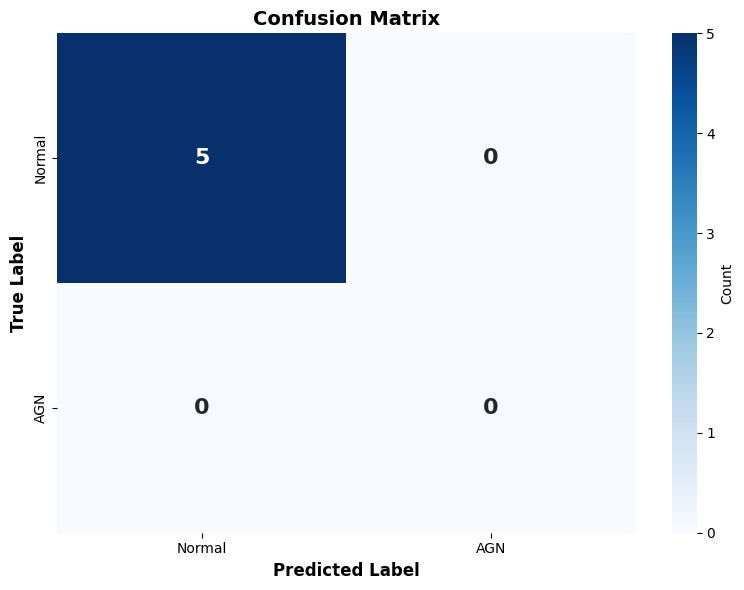


【分類レポート】
⚠️ テストデータに両方のクラスが含まれていません
Accuracy: 100.00%


/tmp/ipykernel_72462/1846481416.py:142: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_72462/1846481416.py:142: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/tozastation/ghq/github.com/tozastation/try-astronomy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tozastation/ghq/github.com/tozastation/try-astronomy/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


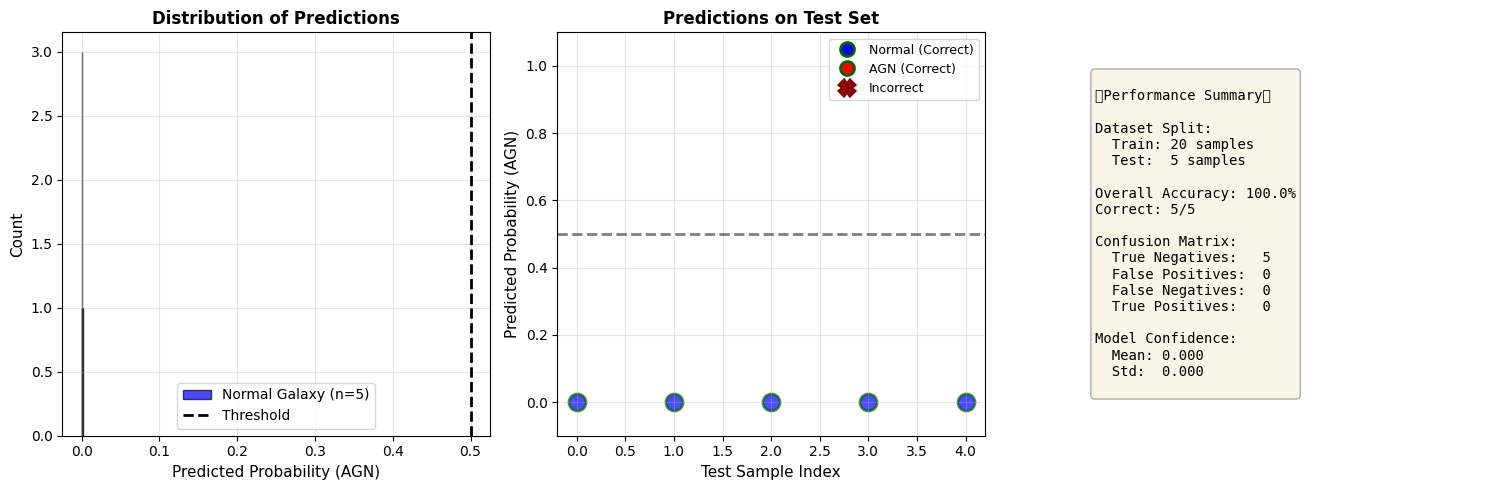


【最終評価サマリー】

データセット:
  訓練サンプル: 20 (AGN=1, Normal=19)
  テストサンプル: 5 (AGN=0, Normal=5)

テストデータ性能:
  正解数: 5/5
  精度: 100.00%

予測の信頼度:
  平均確率: 0.000
  標準偏差: 0.000

✓ 全ての評価が完了しました！

🎉 AGN分類モデルの構築が完了しました！


In [102]:
print("=" * 60)
print("【ステップ6: モデルの詳細評価】")
print("=" * 60)

# テストデータで予測
model.eval()
all_predictions = []
all_probabilities = []
all_true_labels = []

with torch.no_grad():
    for features, labels_batch in test_loader:
        outputs = model(features).squeeze(-1)
        predictions = (outputs > 0.5).float()
        
        all_predictions.extend(predictions.numpy())
        all_probabilities.extend(outputs.numpy())
        all_true_labels.extend(labels_batch.numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_true_labels = np.array(all_true_labels)

# 混同行列
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# クラスラベルを明示的に指定
labels_present = [0, 1]
cm = confusion_matrix(all_true_labels, all_predictions, labels=labels_present)

print("\n【混同行列】")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'AGN'],
            yticklabels=['Normal', 'AGN'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 分類レポート（クラスが存在する場合のみ）
print("\n【分類レポート】")
unique_labels = np.unique(np.concatenate([all_true_labels, all_predictions]))
if len(unique_labels) > 1:
    print(classification_report(all_true_labels, all_predictions, 
                              labels=labels_present,
                              target_names=['Normal Galaxy', 'AGN Candidate'],
                              digits=3,
                              zero_division=0))
else:
    print("⚠️ テストデータに両方のクラスが含まれていません")
    accuracy = accuracy_score(all_true_labels, all_predictions)
    print(f"Accuracy: {accuracy*100:.2f}%")

# 予測確率の分布と結果の可視化
fig = plt.figure(figsize=(15, 5))

# 1. 予測確率の分布
ax1 = plt.subplot(1, 3, 1)
normal_probs = all_probabilities[all_true_labels == 0]
agn_probs = all_probabilities[all_true_labels == 1]

if len(normal_probs) > 0:
    ax1.hist(normal_probs, bins=10, alpha=0.7, label=f'Normal Galaxy (n={len(normal_probs)})', 
             color='blue', edgecolor='black')
if len(agn_probs) > 0:
    ax1.hist(agn_probs, bins=10, alpha=0.7, label=f'AGN Candidate (n={len(agn_probs)})', 
             color='red', edgecolor='black')
ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('Predicted Probability (AGN)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Distribution of Predictions', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. テストデータの予測結果
ax2 = plt.subplot(1, 3, 2)
for i, (prob, label, pred) in enumerate(zip(all_probabilities, all_true_labels, all_predictions)):
    marker = 'o' if pred == label else 'X'
    color = 'blue' if label == 0 else 'red'
    alpha = 0.7 if pred == label else 1.0
    size = 150 if pred == label else 300
    edgecolor = 'darkgreen' if pred == label else 'darkred'
    linewidth = 2 if pred == label else 3
    
    ax2.scatter(i, prob, c=color, marker=marker, s=size, alpha=alpha, 
               edgecolors=edgecolor, linewidths=linewidth)

ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Threshold', alpha=0.5)
ax2.set_xlabel('Test Sample Index', fontsize=11)
ax2.set_ylabel('Predicted Probability (AGN)', fontsize=11)
ax2.set_title('Predictions on Test Set', fontsize=12, fontweight='bold')
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, 
           markeredgecolor='darkgreen', markeredgewidth=2, label='Normal (Correct)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, 
           markeredgecolor='darkgreen', markeredgewidth=2, label='AGN (Correct)'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', markersize=10, 
           markeredgecolor='darkred', markeredgewidth=3, label='Incorrect')
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

# 3. 性能サマリー
ax3 = plt.subplot(1, 3, 3)
ax3.axis('off')

accuracy = accuracy_score(all_true_labels, all_predictions)
correct = np.sum(all_predictions == all_true_labels)
total = len(all_true_labels)

summary_text = f"""
【Performance Summary】

Dataset Split:
  Train: {len(y_train)} samples
  Test:  {len(y_test)} samples

Overall Accuracy: {accuracy*100:.1f}%
Correct: {correct}/{total}

Confusion Matrix:
  True Negatives:  {cm[0,0]:2d}
  False Positives: {cm[0,1]:2d}
  False Negatives: {cm[1,0]:2d}
  True Positives:  {cm[1,1]:2d}

Model Confidence:
  Mean: {all_probabilities.mean():.3f}
  Std:  {all_probabilities.std():.3f}
"""

ax3.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【最終評価サマリー】")
print("=" * 60)
print(f"\nデータセット:")
print(f"  訓練サンプル: {len(y_train)} (AGN={np.sum(y_train==1)}, Normal={np.sum(y_train==0)})")
print(f"  テストサンプル: {len(y_test)} (AGN={np.sum(y_test==1)}, Normal={np.sum(y_test==0)})")
print(f"\nテストデータ性能:")
print(f"  正解数: {correct}/{total}")
print(f"  精度: {accuracy*100:.2f}%")
print(f"\n予測の信頼度:")
print(f"  平均確率: {all_probabilities.mean():.3f}")
print(f"  標準偏差: {all_probabilities.std():.3f}")

print("\n✓ 全ての評価が完了しました！")
print("\n🎉 AGN分類モデルの構築が完了しました！")
